# AED & EEG

## Install libraries

In [2]:
import math, os, re, pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, interpolate
from scipy.fft import fft
import numpy as np
from numpy import NaN

from signal_processing import *
from ieeg_utils import *

## Load data

In [3]:
patients_df = pd.read_excel("../../../Data/selected_patients.xlsx")
patients_df

,hup_id,region,lateralization,weight_kg,r_id
0,138,mesial temporal,left,84.4,278
1,140,mesial temporal,left,56.7,320
2,141,mesial temporal,right,85.7,294
3,142,mesial temporal,left,65.3,295
4,162,mesial temporal,left,47.1,412
5,163,mesial temporal,left,82.1,279
6,164,mesial temporal,left,95.3,386
7,173,mesial temporal,right,76.6,31
8,181,mesial temporal,left,63.0,490
9,185,mesial temporal,left,76.2,332


In [4]:
# Load master_elecs.csv from ./data/
master_elecs_df = pd.read_csv("../../../Data/master_elecs.csv")

# only take the numbers in rid column
master_elecs_df["rid"] = master_elecs_df["rid"].str.extract("(\d+)", expand=False)
master_elecs_df["rid"] = master_elecs_df["rid"].astype(int)

# Drop mni_x, mni_y, mni_z, mm_x, mm_y, mm_z columns
master_elecs_df = master_elecs_df.drop(
    columns=["mni_x", "mni_y", "mni_z", "mm_x", "mm_y", "mm_z"]
)

master_elecs_df

,rid,name,vox_x,vox_y,vox_z,label,soz,resected,spike_rate,engel
0,13,LST01,80.6116,106.5480,64.5941,left inferior temporal,False,False,1.091902,1.0
1,13,LST02,72.0779,109.4150,63.1223,left inferior temporal,False,False,1.091902,1.0
2,13,LST03,64.9060,112.3760,68.7455,EmptyLabel,False,False,1.419472,1.0
3,13,LST04,65.0210,114.6600,78.2339,left middle temporal,False,False,0.655141,1.0
4,13,MST01,131.7410,64.3756,70.4205,right lingual,True,False,3.439490,1.0
...,...,...,...,...,...,...,...,...,...,...
14212,785,RB08,154.2550,114.2730,136.7560,EmptyLabel,False,NaN,0.369914,1.0
14213,785,RB09,159.1350,111.9920,136.6960,EmptyLabel,False,NaN,0.665845,1.0
14214,785,RB10,164.7520,109.9030,137.7640,right middle temporal,False,NaN,4.586930,1.0
14215,785,RB11,169.6320,107.6220,137.7040,right middle temporal,False,NaN,2.071517,1.0


In [5]:
# Load rid_hup_table.csv from ./data/
rid_hup_table_df = pd.read_csv("../../../Data/rid_hup_table.csv")
# Drop the t3_subject_id and ieegportalsubjno columns
rid_hup_table_df = rid_hup_table_df.drop(columns=["t3_subject_id", "ieegportalsubjno"])
rid_hup_table_df

,record_id,hupsubjno
0,623,35
1,624,36
2,625,37
3,626,38
4,627,39
...,...,...
212,534,250
213,923,251
214,918,252
215,864,253


In [6]:
# Load aed_ref_ranges.xlsx from ./data/
aed_ref_ranges_df = pd.read_excel("../../../Data/aed_ref_ranges.xlsx")
# Lowercase Drug column
aed_ref_ranges_df["Drug"] = aed_ref_ranges_df["Drug"].str.lower()
# show unique units
# print(aed_ref_ranges_df["Unit"].unique())
# mg/L and ug/mL are the same
# If Unit is ng/mL, convert to ug/mL
aed_ref_ranges_df.loc[aed_ref_ranges_df["Unit"] == "ng/mL", "Min"] = (
    aed_ref_ranges_df["Min"] / 1000
)
aed_ref_ranges_df.loc[aed_ref_ranges_df["Unit"] == "ng/mL", "Max"] = (
    aed_ref_ranges_df["Max"] / 1000
)
# Add a column that takes the average of Min and Max
aed_ref_ranges_df["Avg"] = (aed_ref_ranges_df["Min"] + aed_ref_ranges_df["Max"]) / 2
aed_ref_ranges_df

,Drug,Min,Max,Unit,Avg
0,levetiracetam,12.00,46.00,mg/L,29.000
1,carbamazepine,4.00,10.00,mg/L,7.000
2,oxcarbazepine,3.00,35.00,ug/mL,19.000
3,clobazam,0.03,0.30,ng/mL,0.165
4,n-desmethylclobazam,0.30,3.00,ng/mL,1.650
5,topiramate,5.00,20.00,mg/L,12.500
6,valproic acid,50.00,125.00,ug/mL,87.500
7,lacosamide,1.00,10.00,ug/mL,5.500
8,felbamate,30.00,60.00,ug/mL,45.000
9,lamotrigine,2.50,15.00,mg/L,8.750


In [7]:
patient_hup_ids = patients_df.hup_id.to_numpy()
patient_weights = patients_df.weight_kg.to_numpy()
assert len(patient_hup_ids) == len(patient_weights)
len(patient_hup_ids)

18

In [8]:
all_patient_hup_ids = pd.read_excel("../../../Data/HUP_implant_dates.xlsx")
all_patient_hup_ids = all_patient_hup_ids["ptID"].to_numpy()
all_patient_hup_ids

array([225, 224, 223, 221, 219, 217, 216, 215, 214, 213, 211, 210, 209,
       208, 207, 206, 205, 204, 202, 201, 199, 197, 196, 195, 194, 193,
       192, 191, 190, 189, 188, 187, 186, 185, 184, 182, 181, 180, 179,
       178, 177, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165,
       164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152,
       151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139,
       138, 137])

In [9]:
# Create a mapping between patient ids and the index of the patient in the patients_df dataframe
patient_hup_id_to_index = {}
for i, patient_id in enumerate(all_patient_hup_ids):
    patient_hup_id_to_index[patient_id] = i

In [10]:
ieeg_offset_row1_df = pd.read_excel("../../../Data/ieeg_offset/row_1.xlsx", header=None)
ieeg_offset_row2_df = pd.read_excel("../../../Data/ieeg_offset/row_2.xlsx", header=None)
ieeg_offset_row3_df = pd.read_excel("../../../Data/ieeg_offset/row_3.xlsx", header=None)

In [11]:
# Load ./data/ieeg_starts.xlsx into a dataframe
ieeg_starts_df = pd.read_excel("../../../Data/ieeg_starts.xlsx")
ieeg_starts_df

,hup_id,ieeg_start
0,225,38.024167
1,224,37.582778
2,223,32.985556
3,221,37.690000
4,219,33.396667
...,...,...
75,141,37.249444
76,140,35.197500
77,139,37.151667
78,138,37.529444


## 3: EEG Experiments

In [12]:
directory_path = "../../../Data/ieeg/mesial_temporal_left_right/5_min/"

### 3.0 Helper Functions

In [13]:
# def create_pwd_file(username, password, fname=None):
#     if fname is None:
#         fname = "{}_ieeglogin.bin".format(username[:3])
#     with open(fname, "wb") as f:
#         f.write(password.encode())
#     print("-- -- IEEG password file saved -- --")


# create_pwd_file("dma", "mycqEv-pevfo4-roqfan")

# with open("dma_ieeglogin.bin", "r") as f:
#     session = Session("dma", f.read())

In [14]:
def identify_bad_channels(values, channel_indices, channel_labels, fs):
    """
    Identifies 'bad' channels in an EEG dataset based on various criteria such as high variance, missing data,
    crossing absolute threshold, high variance above baseline, and 60 Hz noise.

    Parameters:
    values (numpy.ndarray): A 2D array of EEG data where each column is a different channel and each row is a reading.
    channel_indices (list): A list containing indices of channels to be analyzed.
    channel_labels (list): A list of channel labels.
    fs (float): The sampling frequency.

    Returns:
    bad (list): A list of 'bad' channel indices.
    details (dict): A dictionary containing the reasons why each channel was marked as 'bad'. Keys are 'noisy', 'nans',
                    'zeros', 'var', 'higher_std', and 'high_voltage'. Each key maps to a list of channel indices.
    """

    # set parameters
    tile = 99
    mult = 10
    num_above = 1
    abs_thresh = 5e3
    percent_60_hz = 0.99
    mult_std = 10

    bad = []
    high_ch = []
    nan_ch = []
    zero_ch = []
    high_var_ch = []
    noisy_ch = []
    all_std = np.full(len(channel_indices), NaN)

    for i in range(len(channel_indices)):
        bad_ch = 0
        ich = channel_indices[i]
        eeg = values[:, ich]
        bl = np.nanmedian(eeg)

        all_std[i] = np.nanstd(eeg)

        if np.sum(np.isnan(eeg)) > 0.5 * len(eeg):
            bad.append(ich)
            nan_ch.append(ich)
            continue

        if np.sum(eeg == 0) > 0.5 * len(eeg):
            bad.append(ich)
            zero_ch.append(ich)
            continue

        if np.sum(np.abs(eeg - bl) > abs_thresh) > 10:
            bad.append(ich)
            bad_ch = 1
            high_ch.append(ich)

        if bad_ch == 1:
            continue

        pct = np.percentile(eeg, [100 - tile, tile])
        thresh = [bl - mult * (bl - pct[0]), bl + mult * (pct[1] - bl)]
        sum_outside = np.sum((eeg > thresh[1]) | (eeg < thresh[0]))

        if sum_outside >= num_above:
            bad_ch = 1

        if bad_ch == 1:
            bad.append(ich)
            high_var_ch.append(ich)
            continue

        Y = fft(eeg - np.nanmean(eeg))

        P = np.abs(Y) ** 2
        freqs = np.linspace(0, fs, len(P) + 1)
        freqs = freqs[:-1]
        P = P[: int(np.ceil(len(P) / 2))]
        freqs = freqs[: int(np.ceil(len(freqs) / 2))]

        P_60Hz = np.sum(P[(freqs > 58) & (freqs < 62)]) / np.sum(P)

        if P_60Hz > percent_60_hz:
            bad_ch = 1

        if bad_ch == 1:
            bad.append(ich)
            noisy_ch.append(ich)
            continue

    median_std = np.nanmedian(all_std)
    higher_std = [
        channel_indices[i]
        for i in range(len(all_std))
        if all_std[i] > mult_std * median_std
    ]
    bad_std = [ch for ch in higher_std if ch not in bad]
    bad.extend(bad_std)

    details = {
        "noisy": noisy_ch,
        "nans": nan_ch,
        "zeros": zero_ch,
        "var": high_var_ch,
        "higher_std": bad_std,
        "high_voltage": high_ch,
    }

    return bad, details

In [15]:
def parse_files_in_directory(directory_path):
    # Initialize dictionaries for HUP id to maximum hour and sample rate
    max_hours = {}
    sample_rates = {}

    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        # Check if filename contains "D0"
        if "D0" in filename:
            continue
        # Use regular expression to extract the values from the filename
        match = re.match(r"HUP(\d+)_phaseII_hr_(\d+)_fs_(\d+).pkl", filename)
        if match:
            hup_id, hour, sample_rate = map(int, match.groups())

            # If this HUP id is not in max_hours dictionary, or the current hour is greater
            # than the stored maximum hour, update the maximum hour
            if hup_id not in max_hours or hour > max_hours[hup_id]:
                max_hours[hup_id] = hour

            # If this HUP id is not in the sample_rates dictionary, add it
            if hup_id not in sample_rates:
                sample_rates[hup_id] = sample_rate

    # Convert the dictionaries into lists
    hup_ids = list(max_hours.keys())
    max_hours = list(max_hours.values())
    sample_rates = [sample_rates[hup_id] for hup_id in hup_ids]

    return hup_ids, max_hours, sample_rates


# Call the function
hup_ids, max_hours, sample_rates = parse_files_in_directory(directory_path)

# create a dataframe with the HUP id, maximum hour, and sample rate, sort by HUP id
datasets_df = pd.DataFrame(
    {"hup_id": hup_ids, "max_hour": max_hours, "sample_rate": sample_rates}
)
datasets_df = datasets_df.sort_values(by="hup_id")
datasets_df = datasets_df.reset_index(drop=True)
datasets_df

,hup_id,max_hour,sample_rate
0,138,172,1024
1,141,146,512
2,142,311,512
3,173,237,256
4,185,232,512
5,187,177,512
6,190,306,1024
7,202,190,512
8,204,122,512
9,223,135,1024


In [16]:
def create_bipolar_montage(data, channel_names):
    """
    A bipolar montage is a type of arrangement in electrophysiology (like EEG) where each channel shows
    the difference in electrical potential between two different electrodes.

    Args:
        data (numpy.array or similar): A 2D array containing the EEG (or similar) data.
        Each column corresponds to a channel and each row to a time point.

        channel_names (list or similar): An array-like structure with the names of the channels.
        Channel names are expected to follow this format: (Letter)(Letter)[Letter](Number)(Number).

    Returns:
        tuple: A tuple containing two numpy arrays. The first array is the bipolar data and the second array
        is the corresponding channel names.
    """
    channel_names = np.array(channel_names)

    num_channels = len(channel_names)
    bipolar_df = None
    count = 0

    # Iterate over each channel
    for i in range(num_channels - 1):
        channel1_name = channel_names[i]

        # Generate the name of the next sequential channel
        channel2_name = channel1_name[0:2] + f"{(int(channel1_name[2:4]) + 1):02d}"

        # Check if the next sequential channel exists
        channel2_index = np.where(channel_names == channel2_name)[0]

        if len(channel2_index) > 0:
            # Create bipolar channel by subtracting the data of channel2 from channel1
            bipolar_channel = pd.Series(
                (data[:, i] - data[:, channel2_index[0]])
            ).rename(channel1_name)

            # If this is the first bipolar channel, initialize the dataframe
            if count == 0:
                bipolar_df = pd.DataFrame(bipolar_channel)
                count += 1
            else:
                # If the dataframe is already initialized, add the new bipolar channel to it
                bipolar_df = pd.concat(
                    [bipolar_df, pd.DataFrame(bipolar_channel)], axis=1
                )

    return bipolar_df

### 3.2.2: Artifact Rejection

**Conclusions:**
1. Lots of "bad" channels during the first couple hours of EEG recording.
2. Maybe those "bad" channels have contaminated my previous analysis?

### 3.2.3: First Pass with Bipolar Re-Referencing

In [17]:
datasets_df

,hup_id,max_hour,sample_rate
0,138,172,1024
1,141,146,512
2,142,311,512
3,173,237,256
4,185,232,512
5,187,177,512
6,190,306,1024
7,202,190,512
8,204,122,512
9,223,135,1024


In [18]:
# Select rows of patients_df that have hup_id in datasets_df
patients_df = patients_df[patients_df["hup_id"].isin(datasets_df["hup_id"])]
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,region,lateralization,weight_kg,r_id
0,138,mesial temporal,left,84.4,278
1,141,mesial temporal,right,85.7,294
2,142,mesial temporal,left,65.3,295
3,173,mesial temporal,right,76.6,31
4,185,mesial temporal,left,76.2,332
5,187,mesial temporal,right,86.2,522
6,190,mesial temporal,left,105.4,405
7,202,mesial temporal,left,89.0,646
8,204,mesial temporal,left,82.1,596
9,223,mesial temporal,left,101.4,785


In [19]:
frequency_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma": (30, 100),
}

In [20]:
# only include the row in patients_df if hup_id is not 204
patients_df = patients_df[patients_df["hup_id"] != 204]
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,region,lateralization,weight_kg,r_id
0,138,mesial temporal,left,84.4,278
1,141,mesial temporal,right,85.7,294
2,142,mesial temporal,left,65.3,295
3,173,mesial temporal,right,76.6,31
4,185,mesial temporal,left,76.2,332
5,187,mesial temporal,right,86.2,522
6,190,mesial temporal,left,105.4,405
7,202,mesial temporal,left,89.0,646
8,223,mesial temporal,left,101.4,785


38
Doses: Start time: 22.716666666666665 hr, End time: 190.15 hr
172 1024
Processing hour 0 of 172
Processing hour 1 of 172
Processing hour 2 of 172
Processing hour 3 of 172
Processing hour 4 of 172
Processing hour 5 of 172
Processing hour 6 of 172
Processing hour 7 of 172
Processing hour 8 of 172
Processing hour 9 of 172
Processing hour 10 of 172
File HUP138_phaseII_hr_10_fs_1024.pkl not found, skipping hour 10
Processing hour 11 of 172
Processing hour 12 of 172
Processing hour 13 of 172
Processing hour 14 of 172
Processing hour 15 of 172
Processing hour 16 of 172
Processing hour 17 of 172
Processing hour 18 of 172
Processing hour 19 of 172
Processing hour 20 of 172
Processing hour 21 of 172
Processing hour 22 of 172
Processing hour 23 of 172
Processing hour 24 of 172
Processing hour 25 of 172
Processing hour 26 of 172
Processing hour 27 of 172
Processing hour 28 of 172
Processing hour 29 of 172
Processing hour 30 of 172
Processing hour 31 of 172
Processing hour 32 of 172
Processing h

/tmp/ipykernel_58681/1045330125.py:80: RuntimeWarning: invalid value encountered in scalar divide
  P_60Hz = np.sum(P[(freqs > 58) & (freqs < 62)]) / np.sum(P)


Processing hour 100 of 172
Processing hour 101 of 172
Processing hour 102 of 172
Processing hour 103 of 172
Processing hour 104 of 172
Processing hour 105 of 172
Processing hour 106 of 172
Processing hour 107 of 172
Processing hour 108 of 172
Processing hour 109 of 172
Processing hour 110 of 172
Processing hour 111 of 172
Processing hour 112 of 172
Processing hour 113 of 172
Processing hour 114 of 172
Processing hour 115 of 172
Processing hour 116 of 172
Processing hour 117 of 172
Processing hour 118 of 172
Processing hour 119 of 172
Processing hour 120 of 172
Processing hour 121 of 172
Processing hour 122 of 172
Processing hour 123 of 172
Processing hour 124 of 172
Processing hour 125 of 172
Processing hour 126 of 172
Processing hour 127 of 172
Processing hour 128 of 172
Processing hour 129 of 172
Processing hour 130 of 172
Processing hour 131 of 172
Processing hour 132 of 172
Processing hour 133 of 172
Processing hour 134 of 172
Processing hour 135 of 172
Processing hour 136 of 172
P

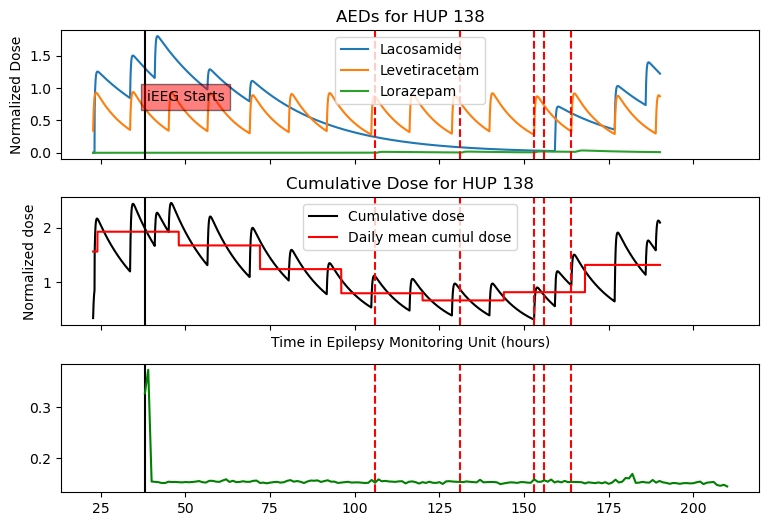

Day with the lowest dosage: 3
Day with the highest dosage: 1


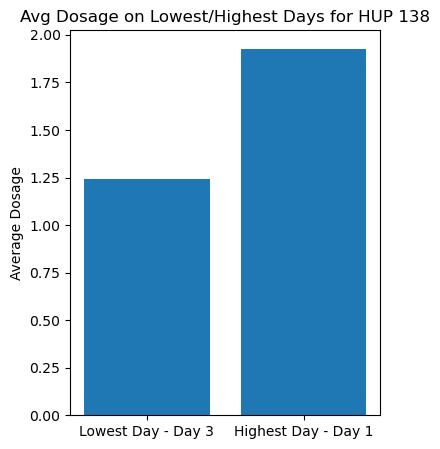

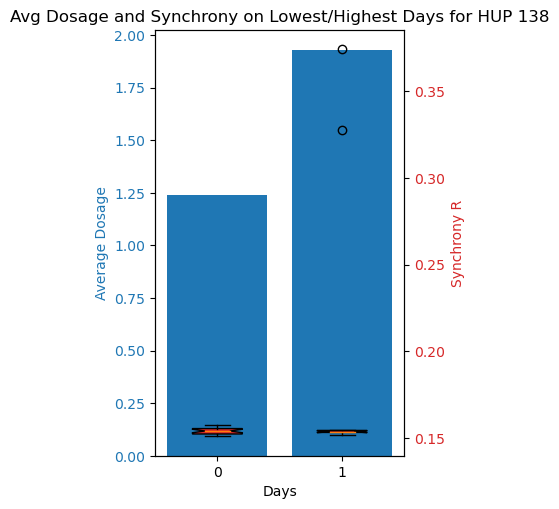

37
Doses: Start time: 18.383333333333333 hr, End time: 194.78333333333333 hr
146 512
Processing hour 0 of 146
Processing hour 1 of 146
Processing hour 2 of 146
Processing hour 3 of 146
Processing hour 4 of 146
Processing hour 5 of 146
Processing hour 6 of 146
Processing hour 7 of 146
Processing hour 8 of 146
Processing hour 9 of 146
Processing hour 10 of 146
Processing hour 11 of 146
Processing hour 12 of 146
Processing hour 13 of 146
Processing hour 14 of 146
Processing hour 15 of 146
Processing hour 16 of 146
Processing hour 17 of 146
Processing hour 18 of 146
Processing hour 19 of 146
Processing hour 20 of 146
Processing hour 21 of 146
Processing hour 22 of 146
Processing hour 23 of 146
Processing hour 24 of 146
Processing hour 25 of 146
Processing hour 26 of 146
Processing hour 27 of 146
Processing hour 28 of 146
Processing hour 29 of 146
Processing hour 30 of 146
Processing hour 31 of 146
Processing hour 32 of 146
Processing hour 33 of 146
Processing hour 34 of 146
Processing hour

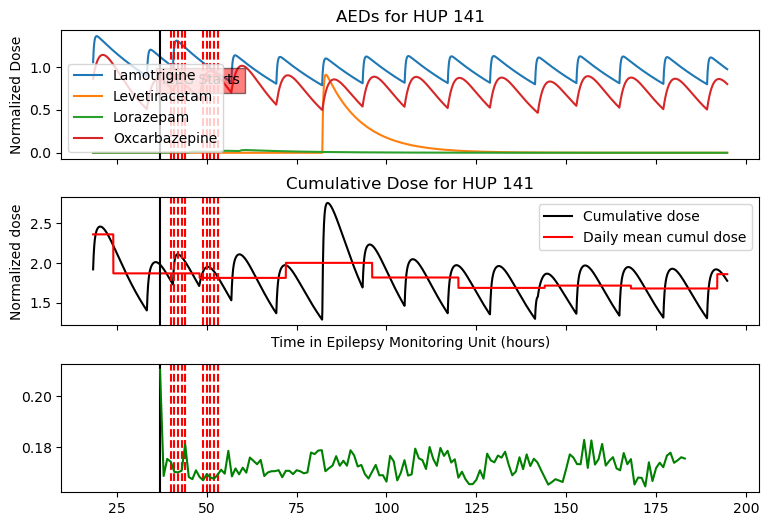

Day with the lowest dosage: 7
Day with the highest dosage: 3


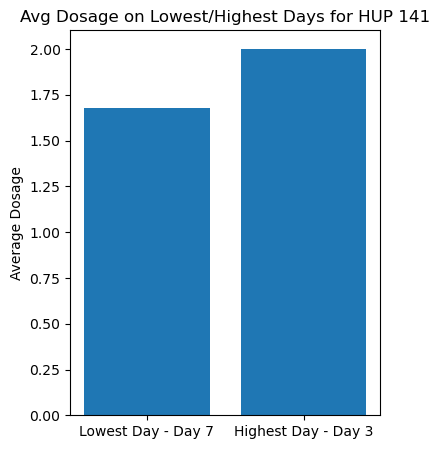

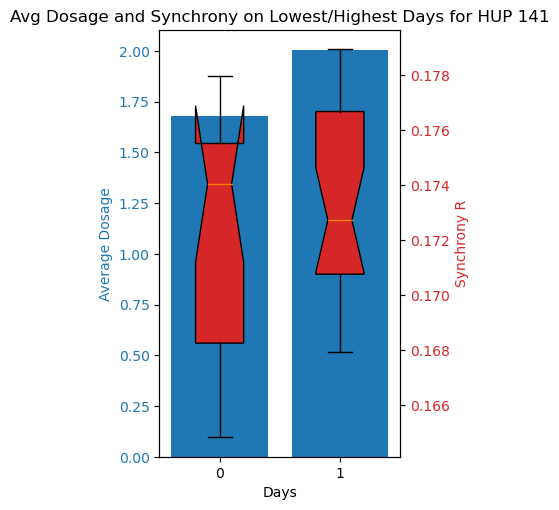

36
Doses: Start time: 22.183333333333334 hr, End time: 360.5833333333333 hr
311 512
Processing hour 0 of 311
Skipping hour 0 because ValueError
Processing hour 1 of 311
Skipping hour 1 because ValueError
Processing hour 2 of 311
Skipping hour 2 because ValueError
Processing hour 3 of 311
Skipping hour 3 because ValueError
Processing hour 4 of 311
Skipping hour 4 because ValueError
Processing hour 5 of 311
Skipping hour 5 because ValueError
Processing hour 6 of 311
Skipping hour 6 because ValueError
Processing hour 7 of 311
Skipping hour 7 because ValueError
Processing hour 8 of 311
Skipping hour 8 because ValueError
Processing hour 9 of 311
Skipping hour 9 because ValueError
Processing hour 10 of 311
Skipping hour 10 because ValueError
Processing hour 11 of 311
Skipping hour 11 because ValueError
Processing hour 12 of 311
Skipping hour 12 because ValueError
Processing hour 13 of 311
Skipping hour 13 because ValueError
Processing hour 14 of 311
Skipping hour 14 because ValueError
Proces

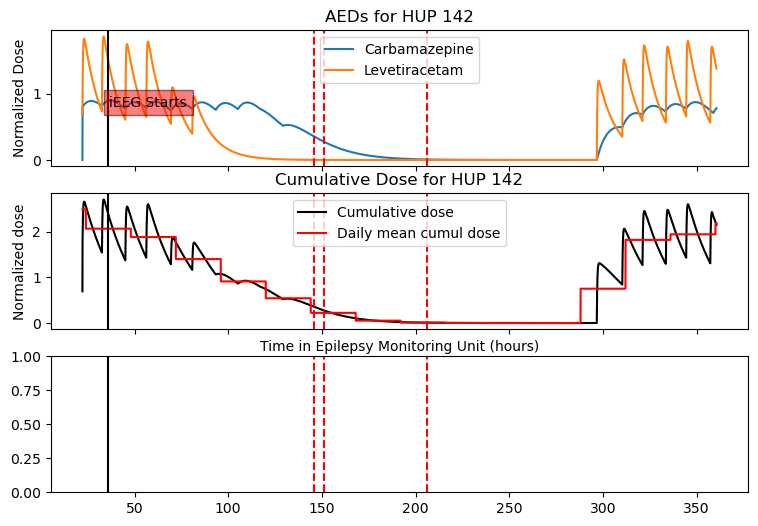

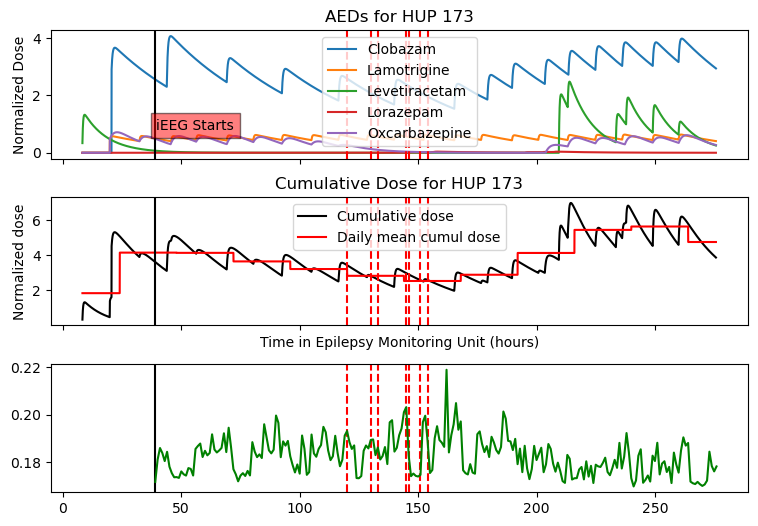

Day with the lowest dosage: 7
Day with the highest dosage: 10


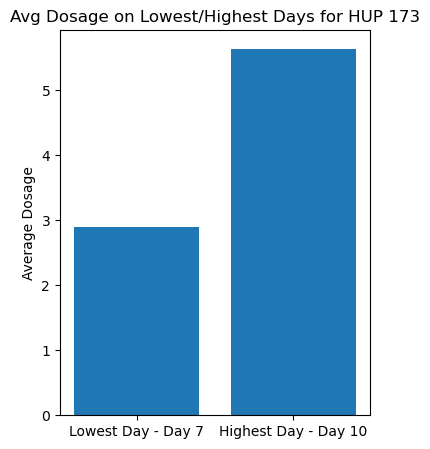

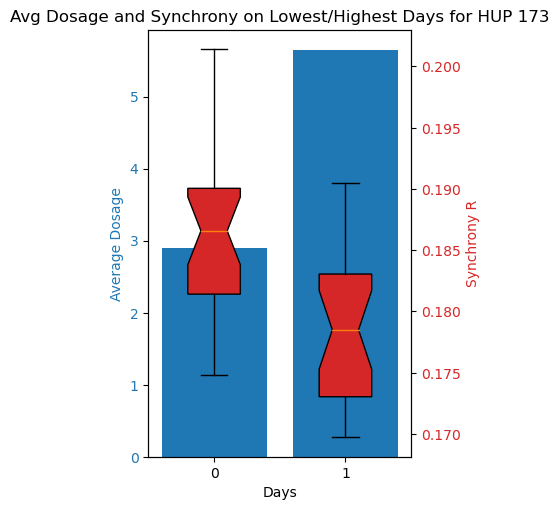

38
Doses: Start time: 8.4 hr, End time: 275.9666666666667 hr
232 512
Processing hour 0 of 232
Processing hour 1 of 232
Processing hour 2 of 232
Processing hour 3 of 232
Processing hour 4 of 232
File HUP185_phaseII_hr_4_fs_512.pkl not found, skipping hour 4
Processing hour 5 of 232
Processing hour 6 of 232
Processing hour 7 of 232
Processing hour 8 of 232
Processing hour 9 of 232
Processing hour 10 of 232
Processing hour 11 of 232
Processing hour 12 of 232
Processing hour 13 of 232
Processing hour 14 of 232
Processing hour 15 of 232
Processing hour 16 of 232
Processing hour 17 of 232
Processing hour 18 of 232
Processing hour 19 of 232
Processing hour 20 of 232
Processing hour 21 of 232
Processing hour 22 of 232
Processing hour 23 of 232
Processing hour 24 of 232
Processing hour 25 of 232
Processing hour 26 of 232
Processing hour 27 of 232
Processing hour 28 of 232
Processing hour 29 of 232
Processing hour 30 of 232
Processing hour 31 of 232
Processing hour 32 of 232
Processing hour 33 o

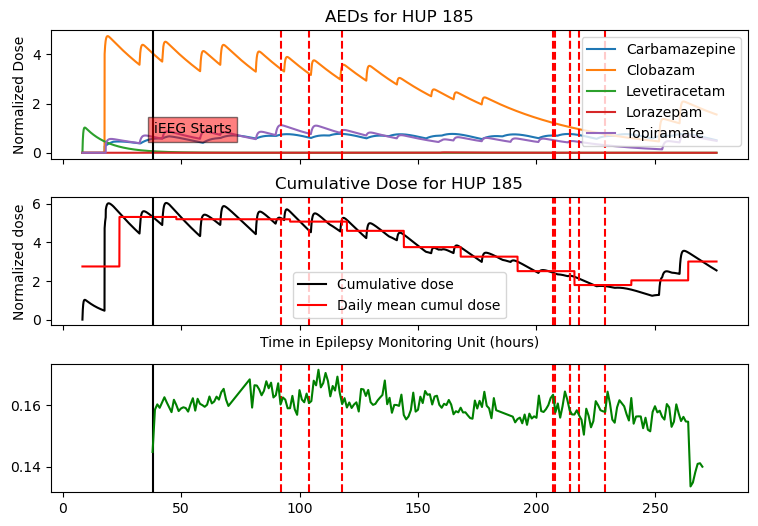

Day with the lowest dosage: 10
Day with the highest dosage: 1


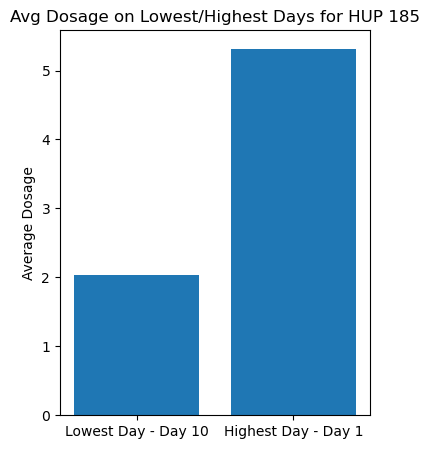

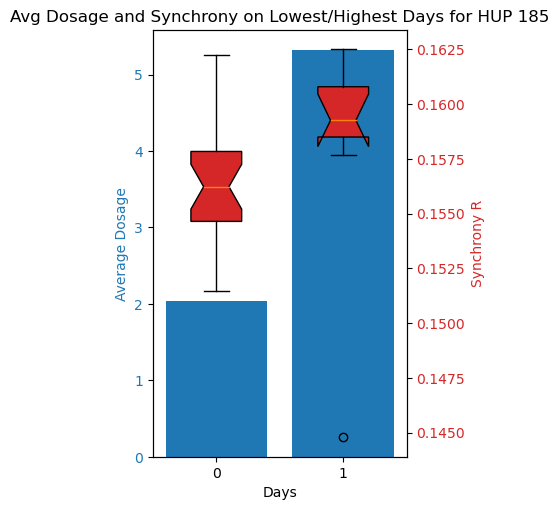

34
Doses: Start time: 14.183333333333334 hr, End time: 199.36666666666667 hr
177 512
Processing hour 0 of 177
Processing hour 1 of 177
Processing hour 2 of 177
Processing hour 3 of 177
Processing hour 4 of 177
Processing hour 5 of 177
Processing hour 6 of 177
Processing hour 7 of 177
Processing hour 8 of 177
Processing hour 9 of 177
Processing hour 10 of 177
Processing hour 11 of 177
Processing hour 12 of 177
Processing hour 13 of 177
Processing hour 14 of 177
Processing hour 15 of 177
Processing hour 16 of 177
Processing hour 17 of 177
Processing hour 18 of 177
Processing hour 19 of 177
Processing hour 20 of 177
Processing hour 21 of 177
Processing hour 22 of 177
Processing hour 23 of 177
Processing hour 24 of 177
Processing hour 25 of 177
Processing hour 26 of 177
Processing hour 27 of 177
Processing hour 28 of 177
Processing hour 29 of 177
Processing hour 30 of 177
Processing hour 31 of 177
Processing hour 32 of 177
Processing hour 33 of 177
Processing hour 34 of 177
Processing hour

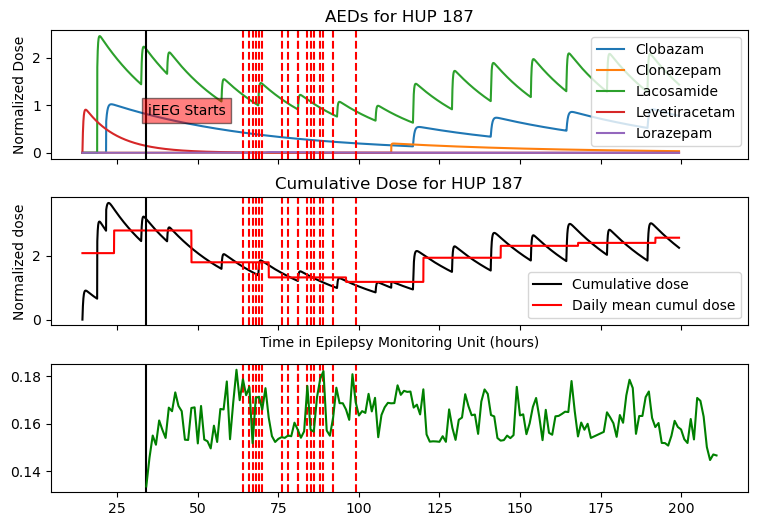

Day with the lowest dosage: 5
Day with the highest dosage: 1


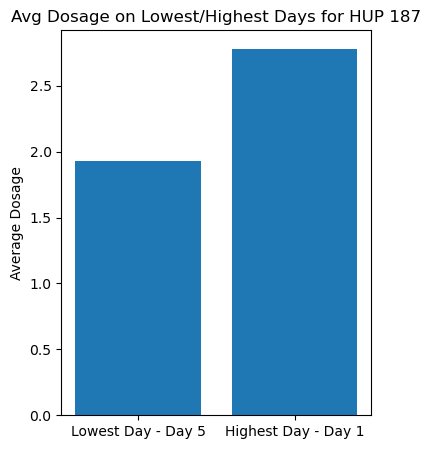

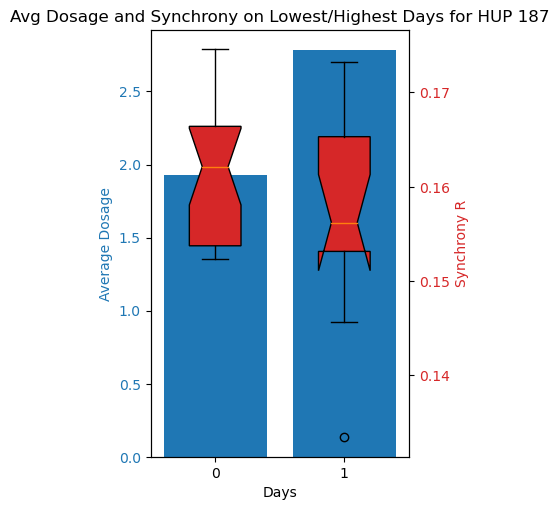

40
Doses: Start time: 8.483333333333333 hr, End time: 348.73333333333335 hr
306 1024
Processing hour 0 of 306
Processing hour 1 of 306
Processing hour 2 of 306
Processing hour 3 of 306
Processing hour 4 of 306
Processing hour 5 of 306
Processing hour 6 of 306
Processing hour 7 of 306
Processing hour 8 of 306
Processing hour 9 of 306
Processing hour 10 of 306
Processing hour 11 of 306
Processing hour 12 of 306
Processing hour 13 of 306
Processing hour 14 of 306
Processing hour 15 of 306
Processing hour 16 of 306
Processing hour 17 of 306
Processing hour 18 of 306
Processing hour 19 of 306
Processing hour 20 of 306
Processing hour 21 of 306
Processing hour 22 of 306
Processing hour 23 of 306
Processing hour 24 of 306
Processing hour 25 of 306
Processing hour 26 of 306
Processing hour 27 of 306
Processing hour 28 of 306
Processing hour 29 of 306
Processing hour 30 of 306
Processing hour 31 of 306
Processing hour 32 of 306
Processing hour 33 of 306
Processing hour 34 of 306
Processing hour

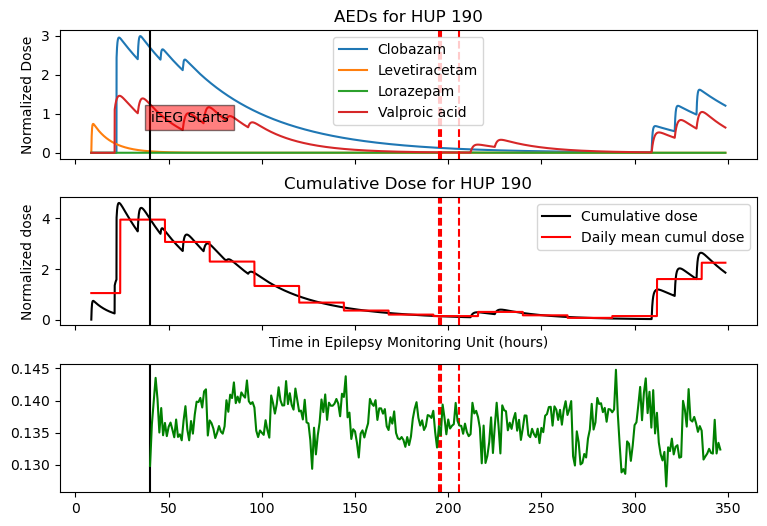

Day with the lowest dosage: 11
Day with the highest dosage: 1


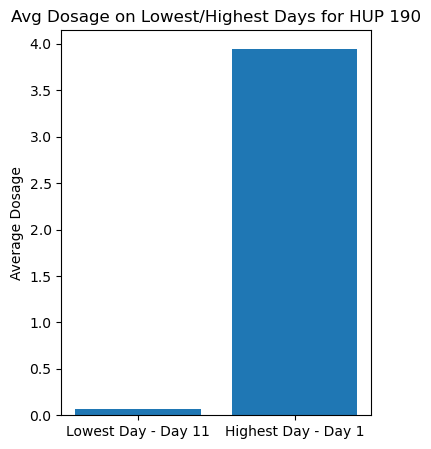

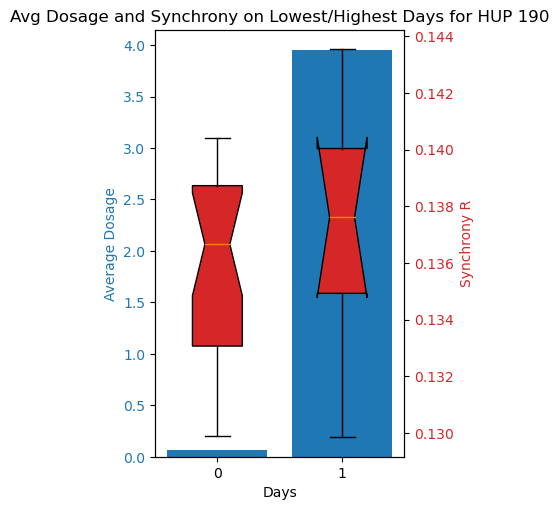

39
Doses: Start time: 8.4 hr, End time: 244.36666666666667 hr
190 512
Processing hour 0 of 190
Processing hour 1 of 190
Processing hour 2 of 190
Processing hour 3 of 190
Processing hour 4 of 190
Processing hour 5 of 190
Processing hour 6 of 190
Processing hour 7 of 190
Processing hour 8 of 190
Processing hour 9 of 190
Processing hour 10 of 190
Processing hour 11 of 190
Processing hour 12 of 190
Processing hour 13 of 190
Processing hour 14 of 190
Processing hour 15 of 190
Processing hour 16 of 190
Processing hour 17 of 190
Processing hour 18 of 190
Processing hour 19 of 190
Processing hour 20 of 190
Processing hour 21 of 190
Processing hour 22 of 190
Processing hour 23 of 190
Processing hour 24 of 190
Processing hour 25 of 190
Processing hour 26 of 190
Processing hour 27 of 190
Processing hour 28 of 190
Processing hour 29 of 190
Processing hour 30 of 190
Processing hour 31 of 190
Processing hour 32 of 190
Processing hour 33 of 190
Processing hour 34 of 190
Processing hour 35 of 190
Proc

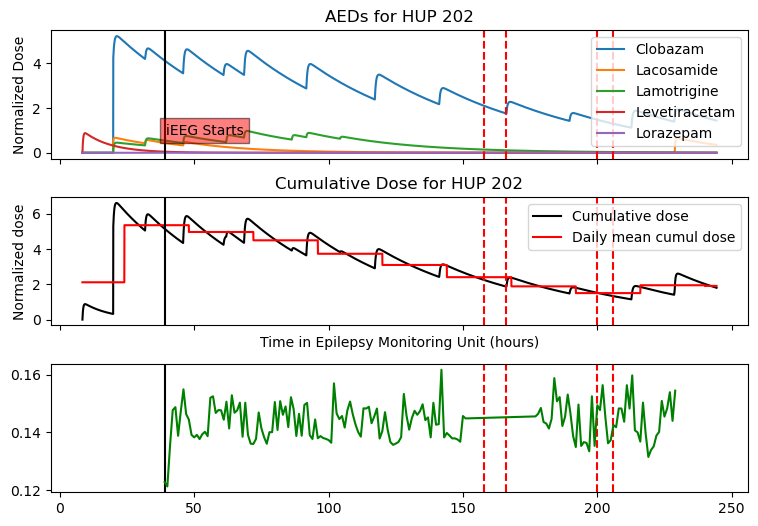

Day with the lowest dosage: 7
Day with the highest dosage: 1


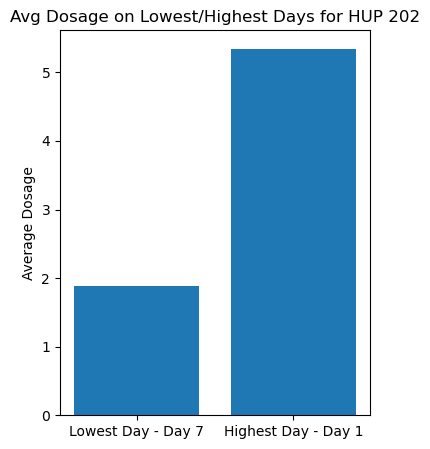

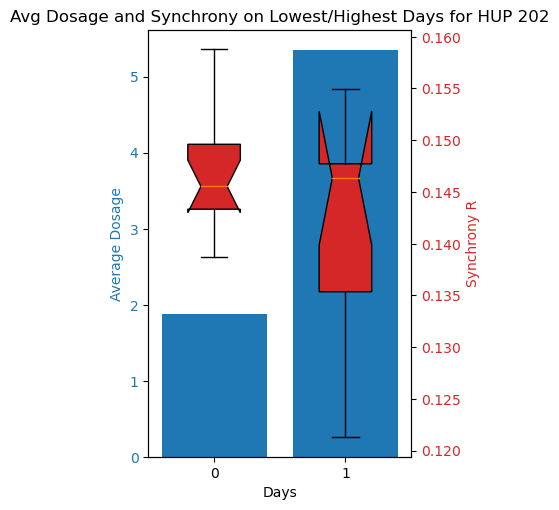

33
Doses: Start time: 13.566666666666666 hr, End time: 223.88333333333333 hr
135 1024
Processing hour 0 of 135
Processing hour 1 of 135
Processing hour 2 of 135
Processing hour 3 of 135
Processing hour 4 of 135
Processing hour 5 of 135
Processing hour 6 of 135
Processing hour 7 of 135
Processing hour 8 of 135
Processing hour 9 of 135
Processing hour 10 of 135
Processing hour 11 of 135
Processing hour 12 of 135
Processing hour 13 of 135
Processing hour 14 of 135
Processing hour 15 of 135
Processing hour 16 of 135
Processing hour 17 of 135
Processing hour 18 of 135
Processing hour 19 of 135
Processing hour 20 of 135
Processing hour 21 of 135
Processing hour 22 of 135
Processing hour 23 of 135
Processing hour 24 of 135
Processing hour 25 of 135
Processing hour 26 of 135
Processing hour 27 of 135
Processing hour 28 of 135
Processing hour 29 of 135
Processing hour 30 of 135
Processing hour 31 of 135
Processing hour 32 of 135
Processing hour 33 of 135
Processing hour 34 of 135
Processing hou

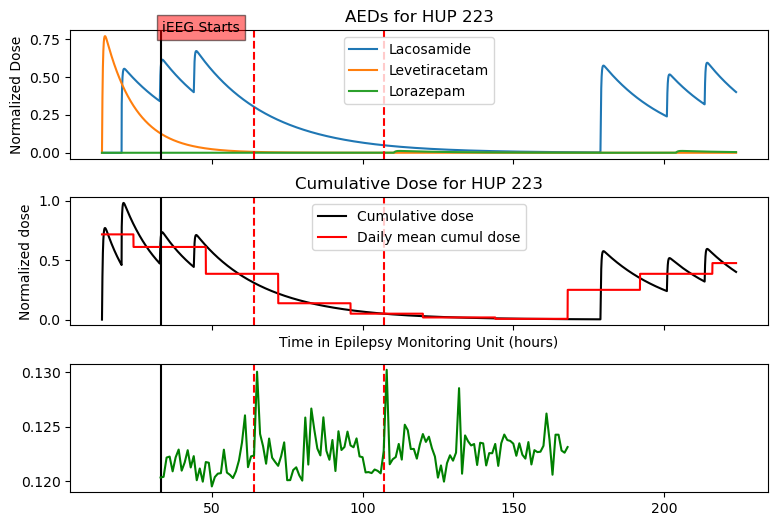

Day with the lowest dosage: 6
Day with the highest dosage: 1


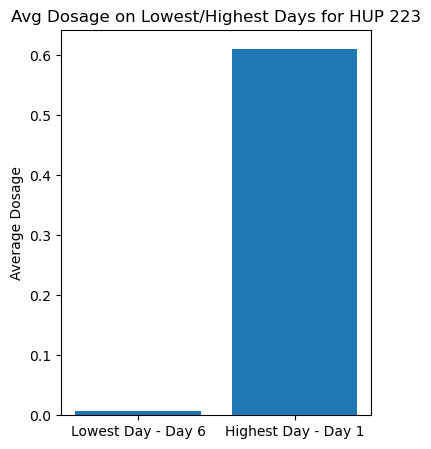

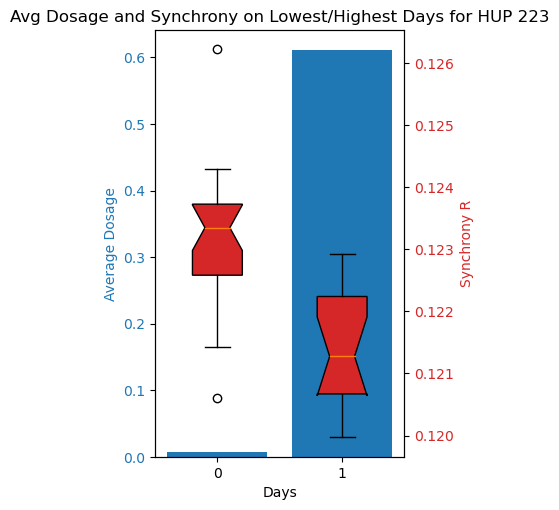

In [21]:
for i, row in patients_df.iterrows():
    # Get patient id and weight
    patient_hup_id, patient_weight = row.hup_id, row.weight_kg
    patient_idx = patient_hup_id_to_index[patient_hup_id]

    # Find the ieeg_start value for patient_hup_id in ieeg_starts_df and convert it into float
    ieeg_start_hrs = float(
        ieeg_starts_df.loc[
            ieeg_starts_df["hup_id"] == patient_hup_id, "ieeg_start"
        ].values[0]
    )
    aligned_emu_start_time_hrs = round(ieeg_start_hrs)

    seizure_times_sec = np.load(
        f"../../../Data/seizures/times/HUP_{patient_hup_id}.npy"
    )
    seizure_times_sec = seizure_times_sec + (ieeg_start_hrs * 3600)

    # Load HUP_{patient_hup_id}.npy from ../../../Data/medications
    aed_np_file = np.load(
        f"../../../Data/medications/HUP_{patient_hup_id}.npy", allow_pickle=True
    )

    all_dose_curves_plot = aed_np_file[0]
    all_tHr_plot = aed_np_file[1]
    all_med_names_plot = aed_np_file[2]

    # Construct the time axis
    emu_start_time_hrs = min([all_tHr_plot[i][0] for i in range(len(all_tHr_plot))])
    emu_end_time_hrs = all_tHr_plot[0][-1]
    max_dose_duration_hrs = emu_end_time_hrs - emu_start_time_hrs
    max_length = max([len(all_tHr_plot[i]) for i in range(len(all_tHr_plot))])
    time_axis = np.linspace(emu_start_time_hrs, emu_end_time_hrs, max_length)
    print(aligned_emu_start_time_hrs)
    # Print start and end times in one line
    print(
        f"Doses: Start time: {emu_start_time_hrs} hr, End time: {emu_end_time_hrs} hr"
    )

    sum_array = []

    # Create two subplots with shared x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(9, 6))

    # Plot dose curves
    for med_idx, med_name in enumerate(all_med_names_plot):
        dose_times = all_tHr_plot[med_idx].flatten()

        # Find Avg for medication med_name in aed_ref_ranges_df
        if med_name == "lorazepam":
            ref_range = 1
        else:
            ref_range = float(
                aed_ref_ranges_df.loc[
                    aed_ref_ranges_df["Drug"] == med_name, "Avg"
                ].values[0]
            )

        # Normalize dose curve according to the middle of the reference range
        dose = all_dose_curves_plot[med_idx].flatten()
        dose = dose / ref_range

        interp_func = interpolate.interp1d(
            dose_times, dose, bounds_error=False, fill_value=0
        )
        dose_interp = interp_func(time_axis)

        if med_name != "lorazepam":
            sum_array.append(dose_interp)

        ax1.plot(time_axis, dose_interp, label=med_name.capitalize())

    # Add legends to the curves
    ax1.legend()
    ax1.set(title=f"AEDs for HUP {patient_hup_id}", ylabel="Normalized Dose")

    cumulative_dose_curve = np.sum(sum_array, axis=0)

    # cumulative_dose_curve = cumulative_dose_curve / cumulative_dose_curve.max()
    assert len(cumulative_dose_curve) == len(
        time_axis
    ), "cumulative_dose_curve and time_axis should have the same length"

    # Convert numpy arrays to pandas DataFrame
    df = pd.DataFrame(data={"Time": time_axis, "Value": cumulative_dose_curve})
    # Create a new column for the integer hour
    df["Hour"] = df["Time"].astype(int)

    # Group by hour and compute mean
    hourly_df = df.groupby("Hour").mean()
    # Create a new column for the day
    df["Day"] = (df["Time"] // 24).astype(int)
    # Group by day and compute mean
    daily_df = df.groupby("Day").mean()

    # Create an array for mean values repeated for each hour
    mean_values_repeated = np.repeat(
        daily_df["Value"].values, df.groupby("Day").size().values
    )
    assert len(mean_values_repeated) == len(
        cumulative_dose_curve
    ), "mean_values_repeated and cumulative_dose_curve should have the same length"

    # Add label to the cumulative dose curve and plot it on the second subplot
    ax2.plot(time_axis, cumulative_dose_curve, label="Cumulative dose", color="black")
    ax2.plot(
        time_axis, mean_values_repeated, label="Daily mean cumul dose", color="red"
    )
    ax2.legend()
    ax2.set(
        title=f"Cumulative Dose for HUP {patient_hup_id}",
        xlabel="Time in Epilepsy Monitoring Unit (hours)",
        ylabel="Normalized dose",
    )

    for seizure_time_sec in seizure_times_sec:
        seizure_time_hr = int(seizure_time_sec[0] / 3600)
        ax1.axvline(x=seizure_time_hr, color="red", linestyle="--")
        ax2.axvline(x=seizure_time_hr, color="red", linestyle="--")
        ax3.axvline(x=seizure_time_hr, color="red", linestyle="--")

    seizure_times_hr = seizure_times_sec / 3600

    # Draw a green vertical line on ax1 and ax2 at the time aligned_emu_start_time_hrs
    ax1.axvline(x=aligned_emu_start_time_hrs, color="black", linestyle="-")
    ax2.axvline(x=aligned_emu_start_time_hrs, color="black", linestyle="-")
    ax3.axvline(x=aligned_emu_start_time_hrs, color="black", linestyle="-")

    # Label it "iEEG Starts", give it red box around it
    ax1.text(
        aligned_emu_start_time_hrs + 0.5,
        0.8,
        "iEEG Starts",
        bbox=dict(facecolor="red", alpha=0.5),
    )

    #########################################
    # Process eeg data
    #########################################

    #########################################
    # Load iEEG data from ./data
    #########################################

    # Create a new dataframe for network metrics
    patient_network_metrics_df = pd.DataFrame(columns=["eeg_hour", "emu_hour", "plv"])

    frequency = (100, 125)

    # Get max_hour value of HUP id in datasets_df
    max_hour = int(datasets_df.loc[datasets_df["hup_id"] == patient_hup_id].max_hour)
    sample_rate = int(
        datasets_df.loc[datasets_df["hup_id"] == patient_hup_id].sample_rate
    )
    print(max_hour, sample_rate)

    eeg_end_time_hrs = max_hour
    selected_eeg_hours = []

    hourly_synchrony = []
    daily_sync = []

    for eeg_hour in range(max_hour + 1):
        print(f"Processing hour {eeg_hour} of {max_hour}")
        filename = f"HUP{patient_hup_id}_phaseII_hr_{eeg_hour}_fs_{sample_rate}.pkl"
        try:
            with open(f"{directory_path}{filename}", "rb") as f:
                eeg_segment_df = pickle.load(f)
                # Use only the first half of samples
                eeg_segment_df = eeg_segment_df.iloc[: int(len(eeg_segment_df) / 2)]
        except FileNotFoundError:
            print(f"File {filename} not found, skipping hour {eeg_hour}")
            continue

        channel_labels = eeg_segment_df.columns.to_numpy(dtype=str)
        channel_indices = np.arange(len(channel_labels))

        bad_channel_indicies, bad_details = identify_bad_channels(
            eeg_segment_df.to_numpy(dtype=float),
            channel_indices,
            channel_labels,
            sample_rate,
        )

        # Get the labels of the good indicies
        # good_channel_labels = np.delete(channel_labels, bad_channel_indicies)
        good_channel_labels = channel_labels

        # Skip this hour if there are less than 2 good channels, i.e., unable to create a bipolar montage
        if len(good_channel_labels) < 2:
            continue

        bad_channel_labels = channel_labels[bad_channel_indicies]

        # get the data in eeg_segment_df that corresponds to the good channels
        good_channels_eeg_segment_df = eeg_segment_df[good_channel_labels]

        try:
            local_res = create_bipolar_montage(
                good_channels_eeg_segment_df.to_numpy(dtype=float), good_channel_labels
            )
        except ValueError:
            print(f"Skipping hour {eeg_hour} because ValueError")
            continue

        # Check if local_res has at least two columns, i.e., at least two good channels in the bipolar montage, otherwise skip this hour
        if local_res is None:
            print(f"Skipping hour {eeg_hour} because bipolar montage is None")
            continue

        if local_res.shape[1] < 2:
            print(
                f"Skipping hour {eeg_hour} because bipolar montage has less than 2 channels"
            )
            continue

        # These are the data we'll process
        # hourly_eeg.append(local_res)
        df_to_be_processed = local_res.T
        df_filtered = process_eeg_data(
            data=df_to_be_processed,
            sample_rate=sample_rate,
            band_pass_freq=frequency_bands["gamma"],
            notch_freq=60,
        )
        R = calculate_kuramoto_order_parameter(df_filtered).mean()
        hourly_synchrony.append(R)
        selected_eeg_hours.append(eeg_hour)
        # Add a row to patient_network_metrics_df with hour=hour and plv=R, using pandas.concat
        patient_network_metrics_df = pd.concat(
            [
                patient_network_metrics_df,
                pd.DataFrame(
                    [[eeg_hour, eeg_hour + aligned_emu_start_time_hrs, R]],
                    columns=["eeg_hour", "emu_hour", "plv"],
                ),
            ]
        )

    if len(selected_eeg_hours) == 0:
        continue

    # Plot emu_hour in patient_network_metrics_df as the x-axis and plv as the y-axis
    ax3.plot(
        patient_network_metrics_df["emu_hour"],
        patient_network_metrics_df["plv"],
        color="green",
    )

    #########################################

    plt.subplots_adjust(hspace=0.3)  # adjust the vertical spacing
    plt.show()

    ###############################
    # Find days with no seizures
    ###############################

    # Add a column for day
    patient_network_metrics_df["emu_day"] = patient_network_metrics_df["emu_hour"] // 24

    # Find the intersection of the days in patient_network_metrics_df and daily_df
    days_in_both = np.intersect1d(
        patient_network_metrics_df["emu_day"], daily_df.index
    ).astype(int)

    # Initialize lists to keep track of days with no seizures
    days_with_no_seizures = []

    # Convert seizure times into days
    seizure_days = seizure_times_hr // 24
    seizure_days = seizure_days.astype(int)

    # Iterate over each emu_day in patient_network_metrics_df
    for day in days_in_both:
        # Check if the day had any seizures
        if day not in seizure_days:
            days_with_no_seizures.append(day)

    # Find days with the lowest and highest dosages
    day_with_lowest_dosage = min(
        days_with_no_seizures,
        key=lambda day: daily_df.loc[day, "Value"],
    )
    day_with_highest_dosage = max(
        days_with_no_seizures,
        key=lambda day: daily_df.loc[day, "Value"],
    )

    # Get the dosages on the lowest and highest days
    lowest_dosage = daily_df.loc[day_with_lowest_dosage, "Value"]
    highest_dosage = daily_df.loc[day_with_highest_dosage, "Value"]

    # Print the day numbers with the lowest and highest dosages
    print(f"Day with the lowest dosage: {day_with_lowest_dosage}")
    print(f"Day with the highest dosage: {day_with_highest_dosage}")

    # Plot the dosages
    plt.figure(figsize=(4, 5))
    plt.bar(
        [
            f"Lowest Day - Day {day_with_lowest_dosage}",
            f"Highest Day - Day {day_with_highest_dosage}",
        ],
        [lowest_dosage, highest_dosage],
    )
    plt.title(f"Avg Dosage on Lowest/Highest Days for HUP {patient_hup_id}")
    plt.ylabel("Average Dosage")
    plt.show()

    # Filter the synchrony_df for the day with the lowest and highest dosage
    lowest_day_sync = patient_network_metrics_df[
        patient_network_metrics_df["emu_day"] == day_with_lowest_dosage
    ]["plv"]
    highest_day_sync = patient_network_metrics_df[
        patient_network_metrics_df["emu_day"] == day_with_highest_dosage
    ]["plv"]

    # Plot the dosages
    fig, ax1 = plt.subplots(figsize=(4, 5))

    color = "tab:blue"
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Average Dosage", color=color)
    ax1.bar(
        [
            f"Lowest Day - Day {day_with_lowest_dosage}",
            f"Highest Day - Day {day_with_highest_dosage}",
        ],
        [lowest_dosage, highest_dosage],
        color=color,
    )
    ax1.tick_params(axis="y", labelcolor=color)

    # Create a second y-axis
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("Synchrony R", color=color)

    # Plot the box plots for the synchrony values
    bp = ax2.boxplot(
        [lowest_day_sync, highest_day_sync],
        positions=[0, 1],
        widths=0.4,
        vert=True,
        patch_artist=True,
        notch=True,
    )

    # Change color of each box
    for patch in bp["boxes"]:
        patch.set(facecolor=color)

    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()
    plt.title(
        f"Avg Dosage and Synchrony on Lowest/Highest Days for HUP {patient_hup_id}"
    )
    plt.show()